### Movie recommender system

### The context
Intelligent recommender systems that can learn to give better recommendations as more information about users is collected. Collaborative Filtering is the most common technique used when it comes to building them.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. You can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

### The content
MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies. 
 - Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

#### Import libraries useful to our exploratoy data analysis

In [60]:
# import libraries

# pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

#### Load data an perform some exploratory data analysis

u.data  
___

The full u data set, 100000 ratings by 943 users on 1682 items.  
Each user has rated at least 20 movies.    
Users and items are numbered consecutively from 1.  
The data is randomly ordered. 
This is a tab separated list of :
 - user id
 - item id
 - rating
 - timestamp. The time stamps are unix seconds since 1/1/1970 UTC   

In [3]:
# put users' rating into a dataframe.
columns_name=["user_id", "item_id", "rating", "timestamp"]
ratings=pd.read_csv('./data/ml-100k/u.data', delim_whitespace=True, names=columns_name) 

In [4]:
# take a look at the data
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# set a better datetime format for the rating and remove the space from the name's column
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.rename(columns={'timestamp':'date_time'}, inplace=True)

In [6]:
ratings.head()

,user_id,item_id,rating,date_time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [7]:
#ratings = ratings.set_index('date_time')

In [8]:
#ratings.head()

In [9]:
ratings.dtypes

user_id               int64
item_id               int64
rating                int64
date_time    datetime64[ns]
dtype: object

In [10]:
# set user_id and item_id as factors
ratings['user_id'] = ratings['user_id'].astype('object')
ratings['item_id'] = ratings['item_id'].astype('object')

In [11]:
ratings.dtypes

user_id              object
item_id              object
rating                int64
date_time    datetime64[ns]
dtype: object

In [12]:
# check if there is any NAs ramaining values to deal with.
ratings.isna().sum()

user_id      0
item_id      0
rating       0
date_time    0
dtype: int64

In [13]:
ratings.date_time.describe()


count                  100000
unique                  49282
top       1998-03-27 21:20:06
freq                       12
first     1997-09-20 03:05:10
last      1998-04-22 23:10:38
Name: date_time, dtype: object

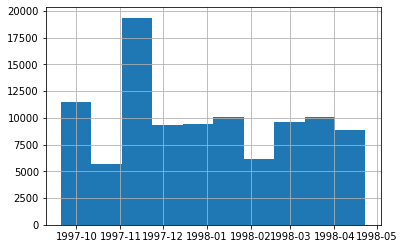

In [41]:
ratings.date_time.hist();

##### Voting period
Ratings have indeed been collected between September 1997 and April 1998.
The ratings seems to have been collected during all this period, with a peak around September 1997

In [15]:
ratings.describe()

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [16]:
ratings.rating.value_counts().sort_index()

1     6110
2    11370
3    27145
4    34174
5    21201
Name: rating, dtype: int64

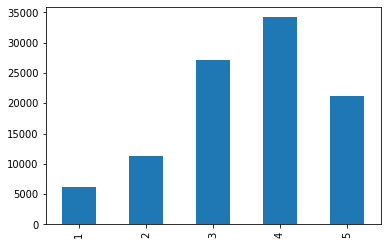

In [17]:
ratings.rating.value_counts().sort_index().plot(kind='bar');

##### Vote tendency
The distributions of the ratings seems to have a negative skewness with a tail on the left. This indicates a general tendency for a rating in the upper scale.

In [52]:
ratings.user_id.value_counts().shape
ratings.user_id.value_counts().head()
ratings.user_id.value_counts().tail()

(943,)

405    737
655    685
13     636
450    540
276    518
Name: user_id, dtype: int64

36     20
34     20
685    20
441    20
202    20
Name: user_id, dtype: int64

In [19]:
ratings.user_id.value_counts().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: user_id, dtype: float64

In [54]:
ratings.user_id.value_counts().value_counts().shape
ratings.user_id.value_counts().value_counts().head()
ratings.user_id.value_counts().value_counts().tail()

(279,)

20    32
21    24
22    23
23    21
24    21
Name: user_id, dtype: int64

134    1
240    1
239    1
238    1
737    1
Name: user_id, dtype: int64

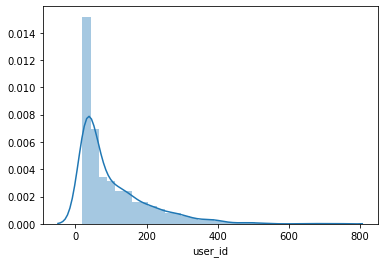

In [21]:
sns.distplot(ratings.user_id.value_counts());

In [55]:
ratings.user_id.value_counts().value_counts().shape
ratings.user_id.value_counts().value_counts().head()
ratings.user_id.value_counts().value_counts().tail()

(279,)

20    32
21    24
22    23
23    21
24    21
Name: user_id, dtype: int64

134    1
240    1
239    1
238    1
737    1
Name: user_id, dtype: int64

##### Users' participation
Some users have been really active, giving up to 737 votes and others have stick to the minimum. The big std indicates this tendency to different number of votes per user. But the distribution of number of votes and the positive skewness and the long left tail indicates that most of them voted around the minimum requiered, and then, the number of voting users decreases significantly while the number of their own votes increases.

In [56]:
ratings.item_id.value_counts().shape
ratings.item_id.value_counts().head()
ratings.item_id.value_counts().tail()

(1682,)

50     583
258    509
100    508
181    507
294    485
Name: item_id, dtype: int64

1452    1
1593    1
1447    1
814     1
1682    1
Name: item_id, dtype: int64

In [57]:
ratings.item_id.value_counts().value_counts().shape
ratings.item_id.value_counts().value_counts().head()
ratings.item_id.value_counts().value_counts().tail()

(273,)

1    141
2     68
4     64
3     60
5     51
Name: item_id, dtype: int64

189    1
188    1
187    1
185    1
142    1
Name: item_id, dtype: int64

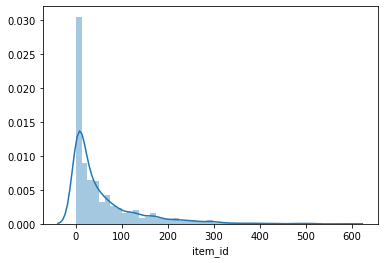

In [25]:
sns.distplot(ratings.item_id.value_counts())

In [27]:
ratings.item_id.value_counts().describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: item_id, dtype: float64

##### Number of votes per movie
The number of votes per movie decreases sharpely from 1, the minimum requiered to be left on the cleaned data set to more than 500.

In [25]:
ratings.groupby('item_id')['rating'].agg([pd.np.mean]).describe()

,mean
count,1682.000000
mean,3.076045
std,0.781662
min,1.000000
25%,2.659600
50%,3.161528
75%,3.653428
max,5.000000


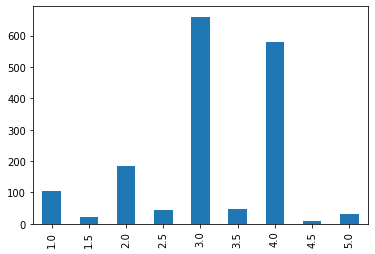

In [31]:
ratings.groupby('item_id')['rating'].agg([pd.np.median])['median'].value_counts().sort_index().plot(kind='bar')

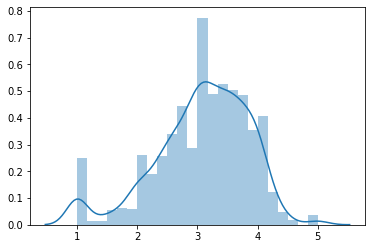

In [27]:
sns.distplot(ratings.groupby('item_id')['rating'].agg([pd.np.mean]))

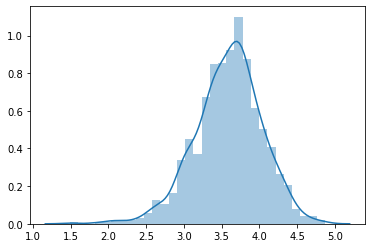

In [29]:
sns.distplot(ratings.groupby('user_id')['rating'].agg([pd.np.mean]))
# users tends to rate a little bit above the average

In [31]:
ratings.groupby('user_id')['rating'].agg([pd.np.mean]).describe()

,mean
count,943.000000
mean,3.588191
std,0.445233
min,1.491954
25%,3.323054
50%,3.620690
75%,3.869565
max,4.869565


##### Movies ratings
Most of users voted slightly above the average,  and most of movies got a slightly above the average vote too.

#### Explanation about how a recommendation engine works

<!--- #![recommendation-engine.png](img/recommendation-engine.png) --->
![Collaborative_filtering.gif](img/Collaborative_filtering.gif)

##### Collaborative Filtering
Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

There are many ways to decide which users are similar and combine their choices to create a list of recommendations. This article will show you how to do that with Python.

In [33]:
# This is the same data that was plotted for similarity earlier
# with one new user "E" who has rated only movie 1
ratings_dict = {
    "item": [1, 2, 1, 2, 1, 2, 1, 2, 1],
    "user": ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E'],
    "rating": [1, 2, 2, 4, 2.5, 4, 4.5, 5, 3],
}
ratings_dict
df = pd.DataFrame(ratings_dict)
df
reader = Reader(rating_scale=(1, 5))
reader
# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
# Loads the builtin Movielens-100k data
movielens = Dataset.load_from_file("./data/ml-100k/u.data", reader)
movielens


# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, movielens, measures=['RMSE', 'MAE'], cv=5, verbose=True)

{'item': [1, 2, 1, 2, 1, 2, 1, 2, 1],
 'user': ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E'],
 'rating': [1, 2, 2, 4, 2.5, 4, 4.5, 5, 3]}

,item,user,rating
0,1,A,1.0
1,2,A,2.0
2,1,B,2.0
3,2,B,4.0
4,1,C,2.5
5,2,C,4.0
6,1,D,4.5
7,2,D,5.0
8,1,E,3.0


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9427  0.9356  0.9327  0.9362  0.9322  0.9359  0.0038  
MAE (testset)     0.7423  0.7385  0.7354  0.7363  0.7365  0.7378  0.0025  
Fit time          7.56    7.64    7.88    7.62    6.72    7.48    0.40    
Test time         0.21    0.34    0.17    0.24    0.17    0.22    0.06    


{'test_rmse': array([0.94274263, 0.93560103, 0.93268967, 0.93619703, 0.93222845]),
 'test_mae': array([0.74228243, 0.73850368, 0.73541934, 0.73632215, 0.73653747]),
 'fit_time': (7.55733847618103,
  7.63639235496521,
  7.880605697631836,
  7.619381904602051,
  6.724764585494995),
 'test_time': (0.20516347885131836,
  0.34224724769592285,
  0.1701209545135498,
  0.23618721961975098,
  0.16911983489990234)}

In [34]:
# recommender.py

from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [35]:


trainingSet = movielens.build_full_trainset()

algo.fit(trainingSet)



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [36]:
prediction = algo.predict('E', 2)
prediction.est

3.52986

Ressources :
- https://surprise.readthedocs.io/
- http://surpriselib.com/
- https://www.kernix.com/article/recommender-system-based-on-natural-language-processing/
- https://realpython.com/build-recommendation-engine-collaborative-filtering/
- https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
- https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
- https://www.datacamp.com/community/tutorials/recommender-systems-python
- https://medium.com/code-heroku/building-a-movie-recommendation-engine-in-python-using-scikit-learn-c7489d7cb145
- https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
- https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/
- https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
- https://towardsdatascience.com/the-4-recommendation-engines-that-can-predict-your-movie-tastes-109dc4e10c52


    